# STEP2: pre-project
We use our previous work `scglue` to project cells from different modalities into same latent feature space. Please follow tutorial [here](https://scglue.readthedocs.io/en/latest/) 
> NOTE: You should install `scglue` manually, in our test `scglue` can install it in `SLAT` conda environment directly. 

In [1]:
import itertools
import anndata as ad
import numpy as np
import pandas as pd
import networkx as nx
import scanpy as sc
import scglue
import scipy
import seaborn as sns
from scipy.sparse import csr_matrix
from matplotlib import rcParams
import anndata
import os
scglue.__version__

'0.2.3'

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
scglue.plot.set_publication_params()
sc.set_figure_params(dpi=160)

# Load ATAC peak from Signac

In [5]:
peak = pd.read_csv('./seurat_peaks.csv')

In [6]:
var = pd.read_csv('./seurat_var.csv')
var.index = var['seqnames'] + ':' + var['start'].astype(str)+ '-' + var['end'].astype(str)

In [7]:
spatial_info = pd.read_csv('../../data/spatial_ATAC/ME11_20um/ME11_20um_spatial/tissue_positions_list.csv',header=None)
spatial_info.columns = ['barcode','suffix','x1','x2','p1','p2']
spatial_info.head()

barcode  suffix  x1  x2   p1    p2
0  AACGTGATAACGTGAT       1   0   0  491  1203
1  AACGTGATAAACATCG       1   1   0  504  1203
2  AACGTGATATGCCTAA       1   2   0  517  1203
3  AACGTGATAGTGGTCA       1   3   0  529  1203
4  AACGTGATACCACTGT       1   4   0  542  1203

In [8]:
obs = pd.DataFrame(peak.columns, columns= ['barcode'])
obs['barcode'] = obs['barcode'].str.split('-').str[0]
meta = pd.read_csv('./meta.csv')
meta['Barcodes_cut'] = meta['Barcodes'].str.split('#').str[1].str.split('-').str[0]
# obs.head
obs = obs.merge(right=spatial_info,left_on='barcode',right_on='barcode')
obs = obs.merge(right=meta,left_on='barcode',right_on='Barcodes_cut')
obs.head()

barcode  suffix  x1  x2   p1    p2                      Barcodes  \
0  ATTGAGGAACGCTCGA       1  20  28  746   903  ME11_20um#ATTGAGGAACGCTCGA-1   
1  AAGACGGAAGAGTCAA       1  23  15  784  1042  ME11_20um#AAGACGGAAGAGTCAA-1   
2  GAATCTGAATCCTGTA       1  27  45  835   720  ME11_20um#GAATCTGAATCCTGTA-1   
3  CCGAAGTAGACTAGTA       1  30  36  874   817  ME11_20um#CCGAAGTAGACTAGTA-1   
4  CCGAAGTACCAGTTCA       1  35  36  937   817  ME11_20um#CCGAAGTACCAGTTCA-1   

      Sample  TSSEnrichment  ReadsInTSS  ...  PromoterRatio  PassQC  \
0  ME11_20um          6.028        1586  ...       0.085004       1   
1  ME11_20um          3.049         562  ...       0.028859       1   
2  ME11_20um          5.508        1488  ...       0.085748       1   
3  ME11_20um          5.520        1221  ...       0.072982       1   
4  ME11_20um          2.435         300  ...       0.030294       1   

   NucleosomeRatio  nMultiFrags  nMonoFrags  nFrags  nDiFrags  BlacklistRatio  \
0         0.802107         7326       25433   45833     13074        0.020269   
1         0.765276        10285       33026   58300     14989        0.036509   
2         0.885704         6832       21488   40520     12200        0.019003   
3         0.799285         6594       22644   40743     11505        0.020433   
4         0.802216         5710       16695   30088      7683        0.028466   

   Clusters      Barcodes_cut  
0        C6  ATTGAGGAACGCTCGA  
1        C1  AAGACGGAAGAGTCAA  
2        C7  GAATCTGAATCCTGTA  
3        C7  CCGAAGTAGACTAGTA  
4        C1  CCGAAGTACCAGTTCA  

[5 rows x 22 columns]

In [9]:
spatial = obs[['p1','p2']].to_numpy()

In [10]:
peak_filter = peak.loc[:,peak.columns.isin(obs.barcode+'-1')]
peak_filter.shape

(33480, 2099)

In [11]:
atac = ad.AnnData(X=peak_filter.T.to_numpy(),obs=obs,var=var,obsm={'spatial':spatial})
np.count_nonzero(atac.X)/(atac.X.shape[0]*atac.X.shape[1])

/tmp/ipykernel_2507824/1477232134.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac = ad.AnnData(X=peak_filter.T.to_numpy(),obs=obs,var=var,obsm={'spatial':spatial})
/rd2/user/xiacr/spatialGLUE/env/glue/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.07323046816968654

/rd2/user/xiacr/spatialGLUE/env/glue/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/rd2/user/xiacr/spatialGLUE/env/glue/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


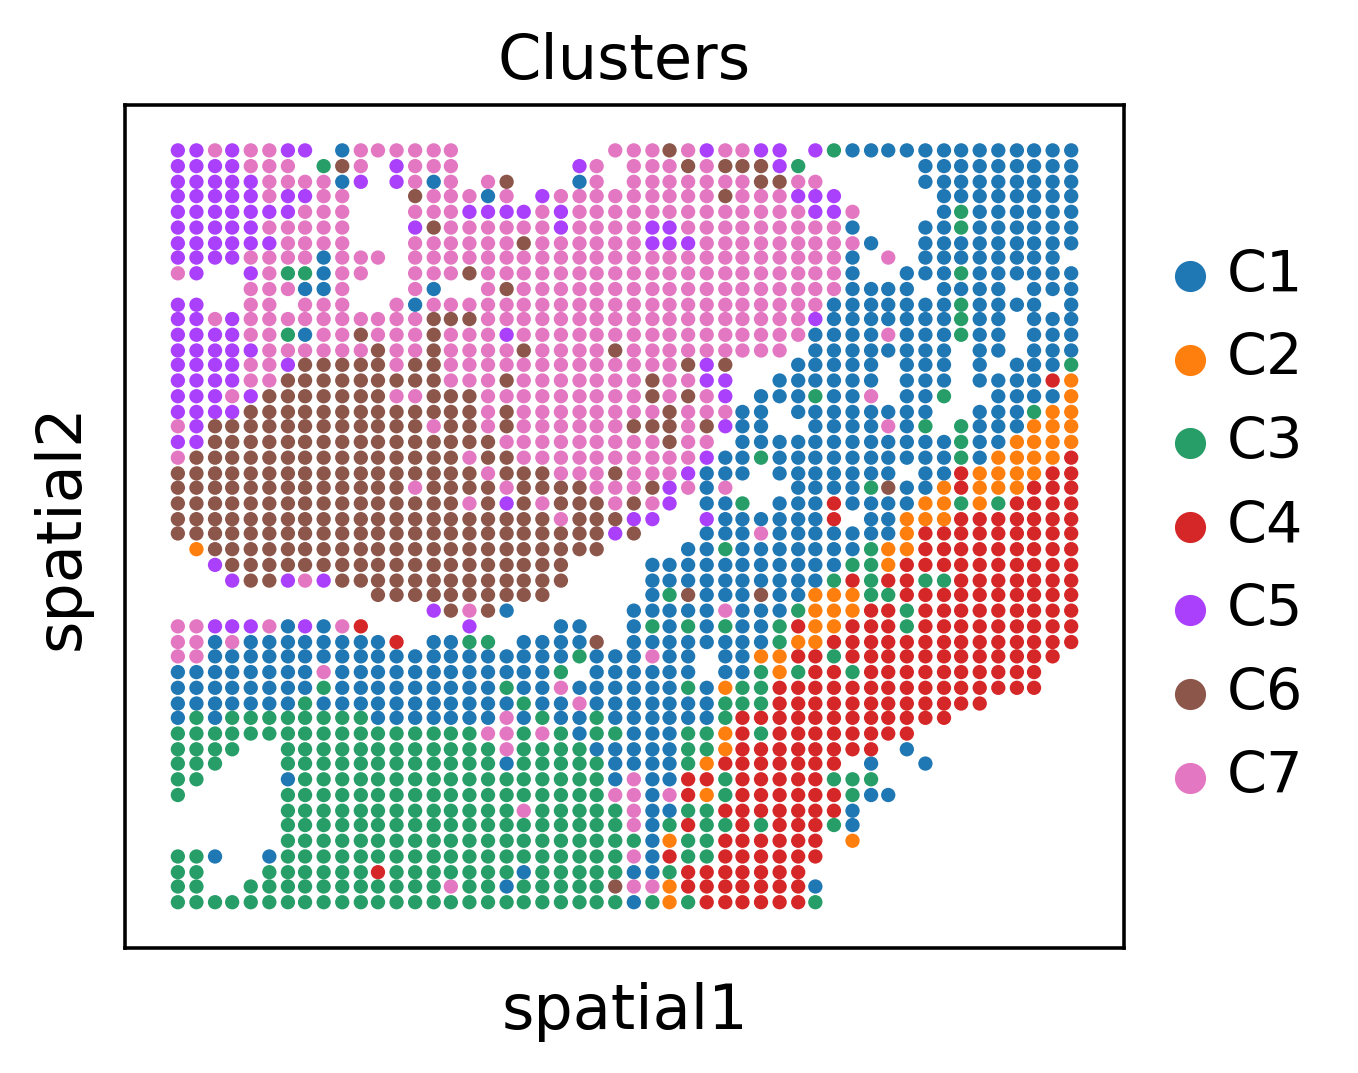

In [12]:
# sc.pl.spatial(atac, spot_size=20, color='Clusters')
atac = atac[atac.obs['suffix'] == 1]
sc.pl.spatial(atac, spot_size=10, color='Clusters')

In [13]:
scglue.data.lsi(atac, n_components=100, n_iter=15)
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.tl.leiden(atac, resolution=0.6)

/rd2/user/xiacr/spatialGLUE/env/glue/conda/lib/python3.8/site-packages/sklearn/utils/extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


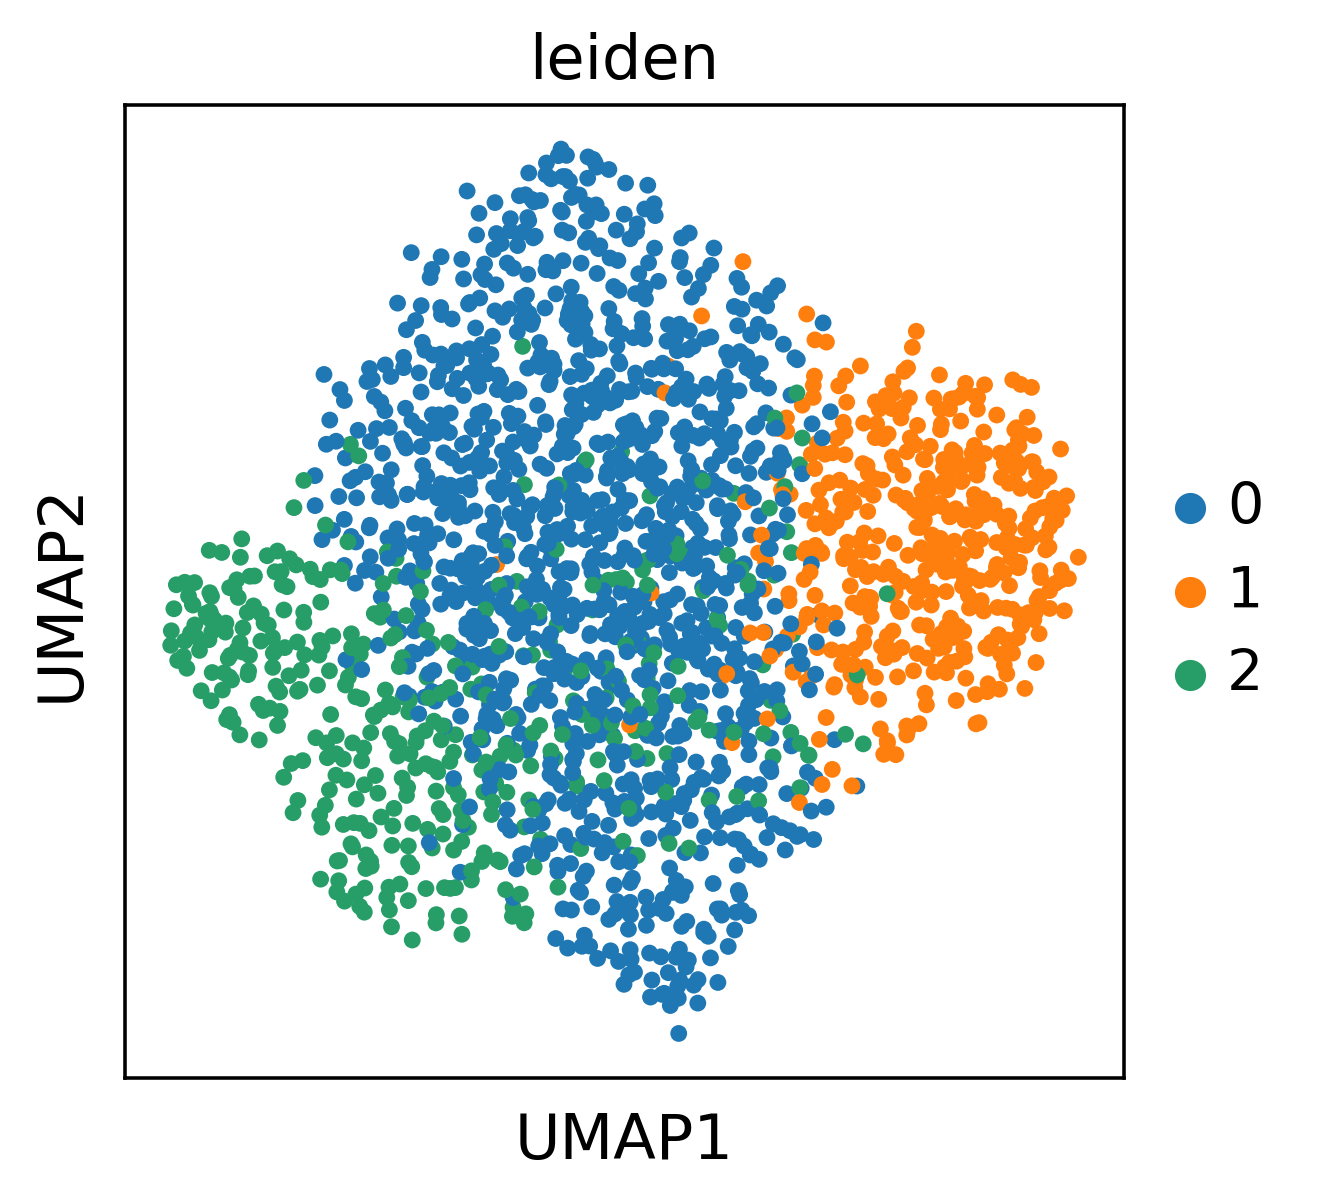

In [14]:
sc.pl.umap(atac, color = ['leiden'])

# RNA split

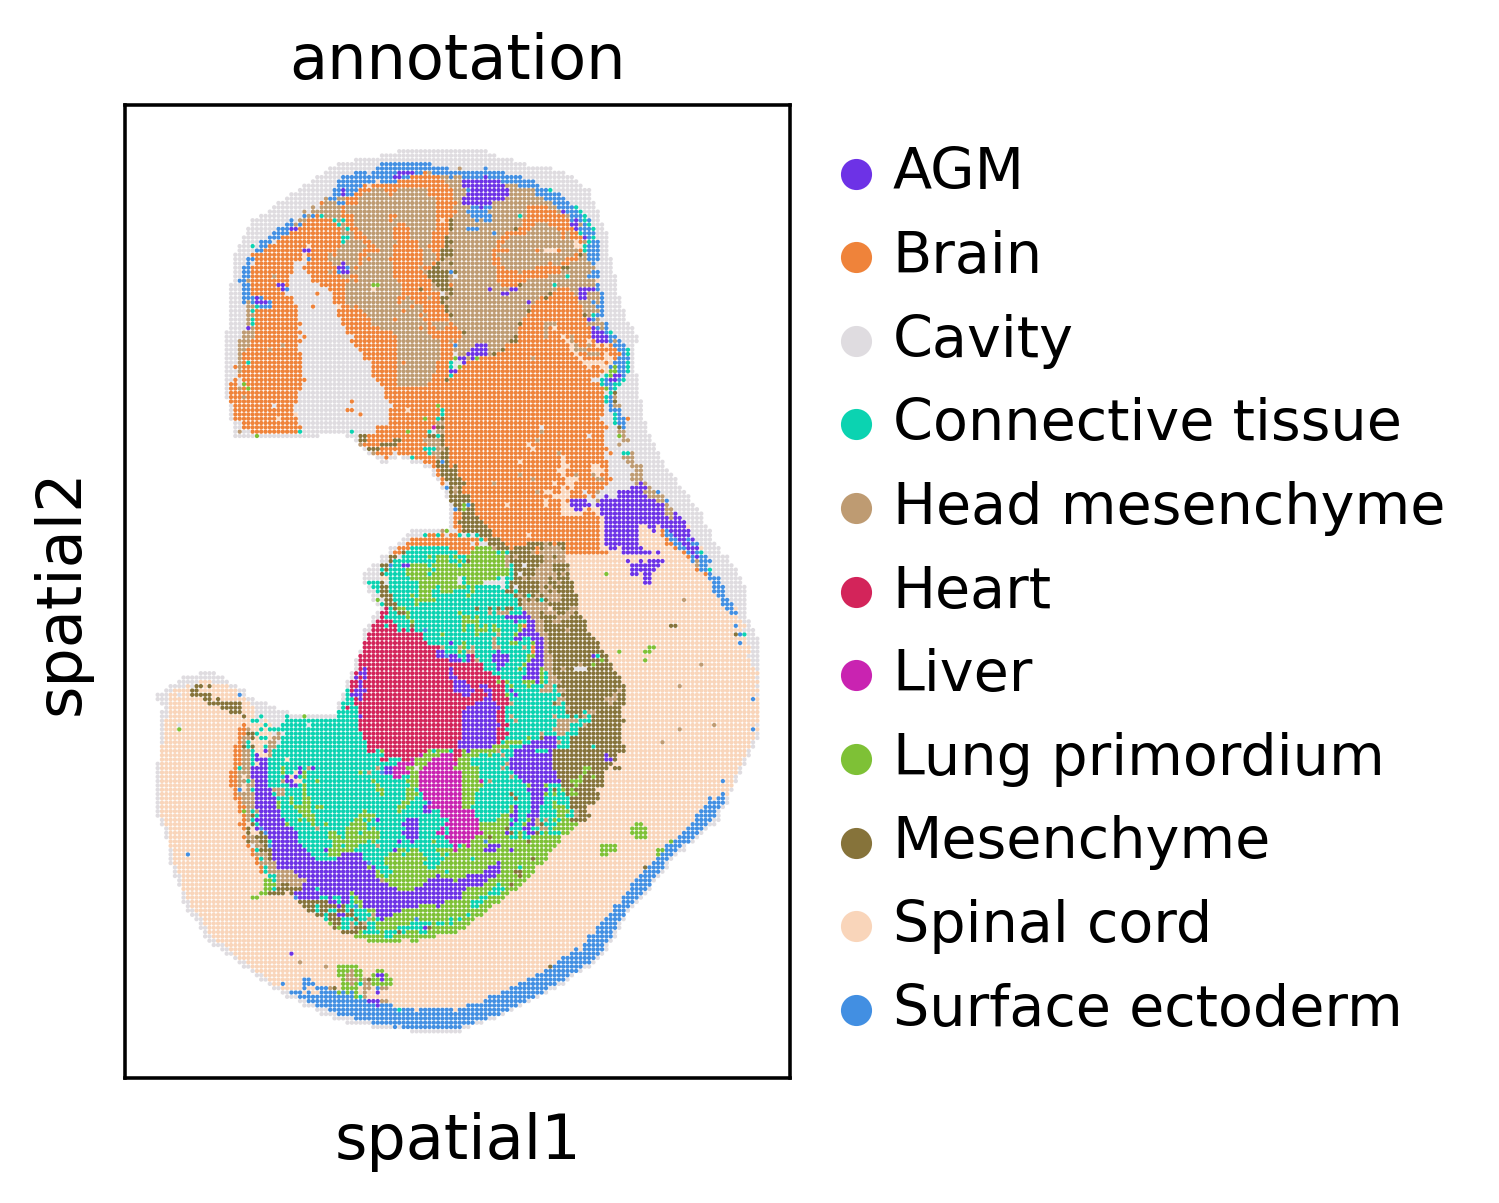

In [15]:
rna = ad.read_h5ad('../../data/stereo_seq/counts/E10.5/count_E10.5_E1S2.MOSTA.h5ad')
rna.X[0:5,0:5].todense()
sc.pl.spatial(rna,spot_size=1,color='annotation')

In [16]:
print(np.max(rna.obsm['spatial'][:,0])) #363 # x
print(np.min(rna.obsm['spatial'][:,0])) #55
print(np.max(rna.obsm['spatial'][:,1])) #566 # y
print(np.min(rna.obsm['spatial'][:,1])) #175

-283.0
-422.0
-119.99999999999996
-323.99999999999994


In [17]:
# mask the different cells
x_mask = np.logical_and(rna.obsm['spatial'][:,0] > -390,rna.obsm['spatial'][:,0] < -300) # left right
y_mask = np.logical_and(rna.obsm['spatial'][:,1] > -260,rna.obsm['spatial'][:,1] < -190) # top down
cell_mask = np.logical_and(x_mask,y_mask)
rna = rna[cell_mask,:].copy()
rna

AnnData object with n_obs × n_vars = 4894 × 25544
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'annotation_colors'
    obsm: 'spatial'
    varm: 'PCs'

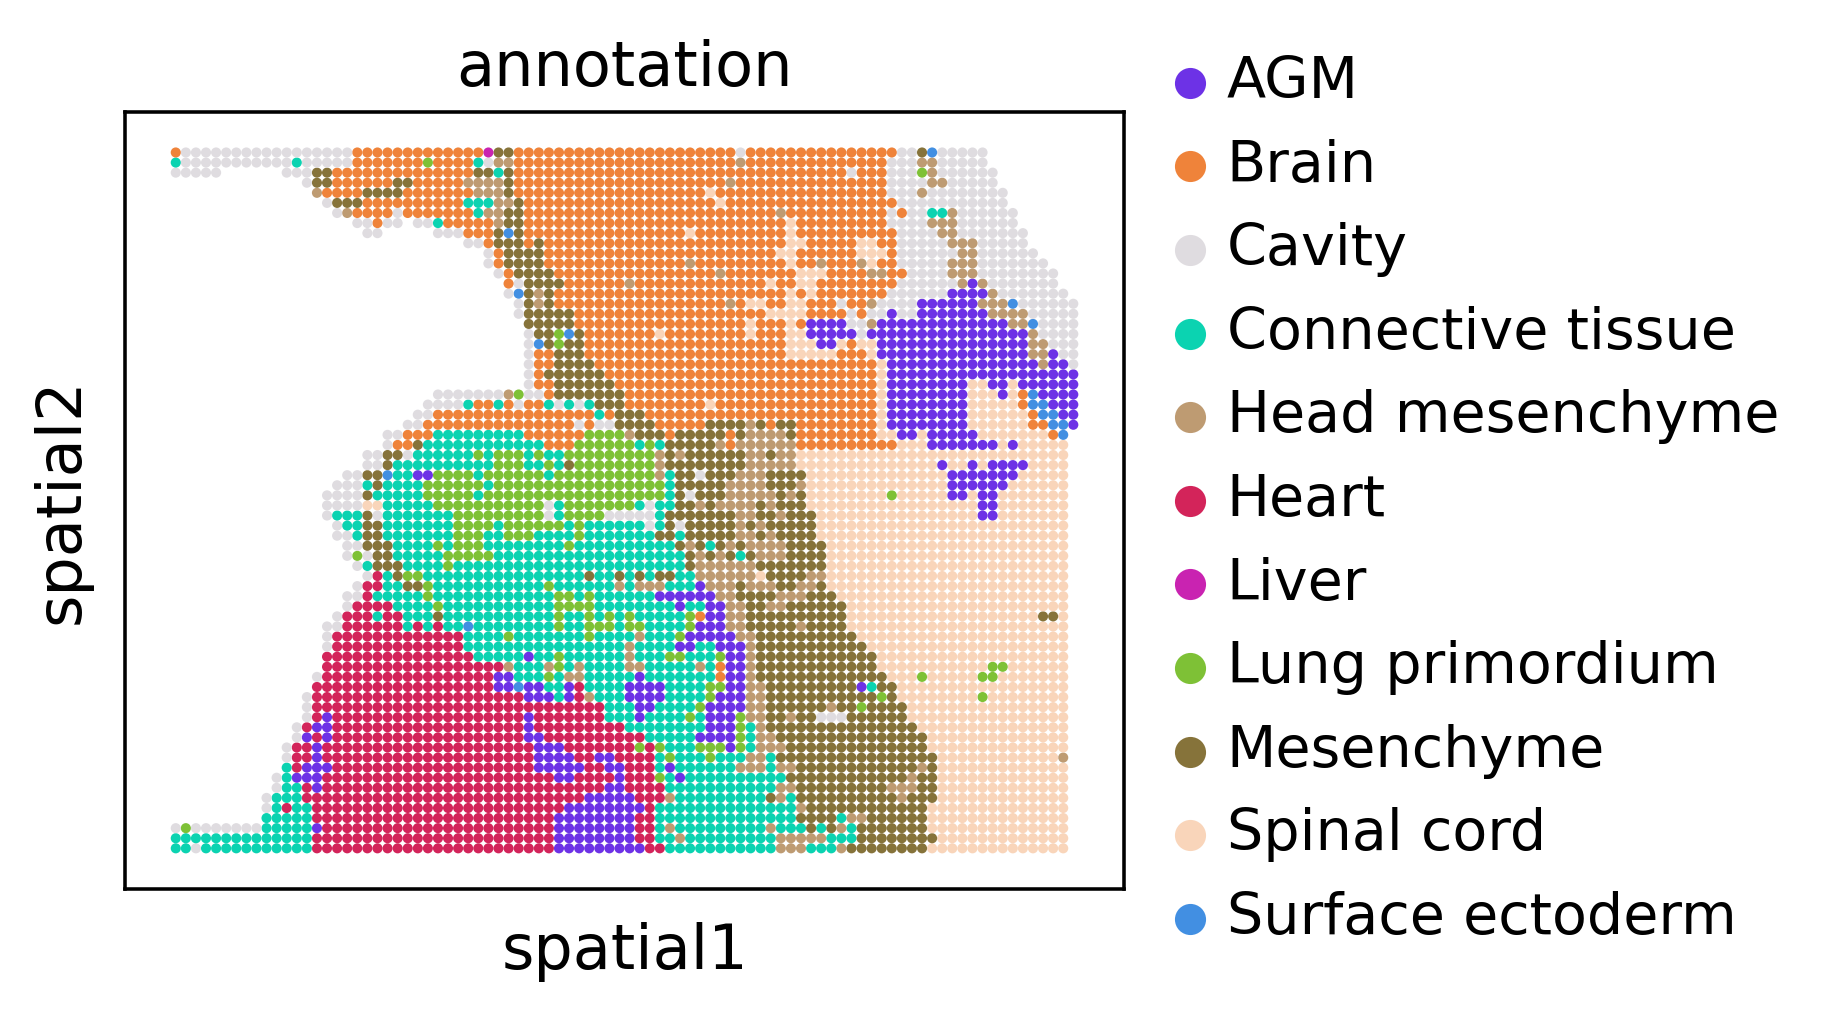

In [18]:
# sc.pl.spatial(rna, color="annotation", spot_size=1,crop_coord = [90,325,220,475])
sc.pl.spatial(rna, color="annotation", spot_size=1)

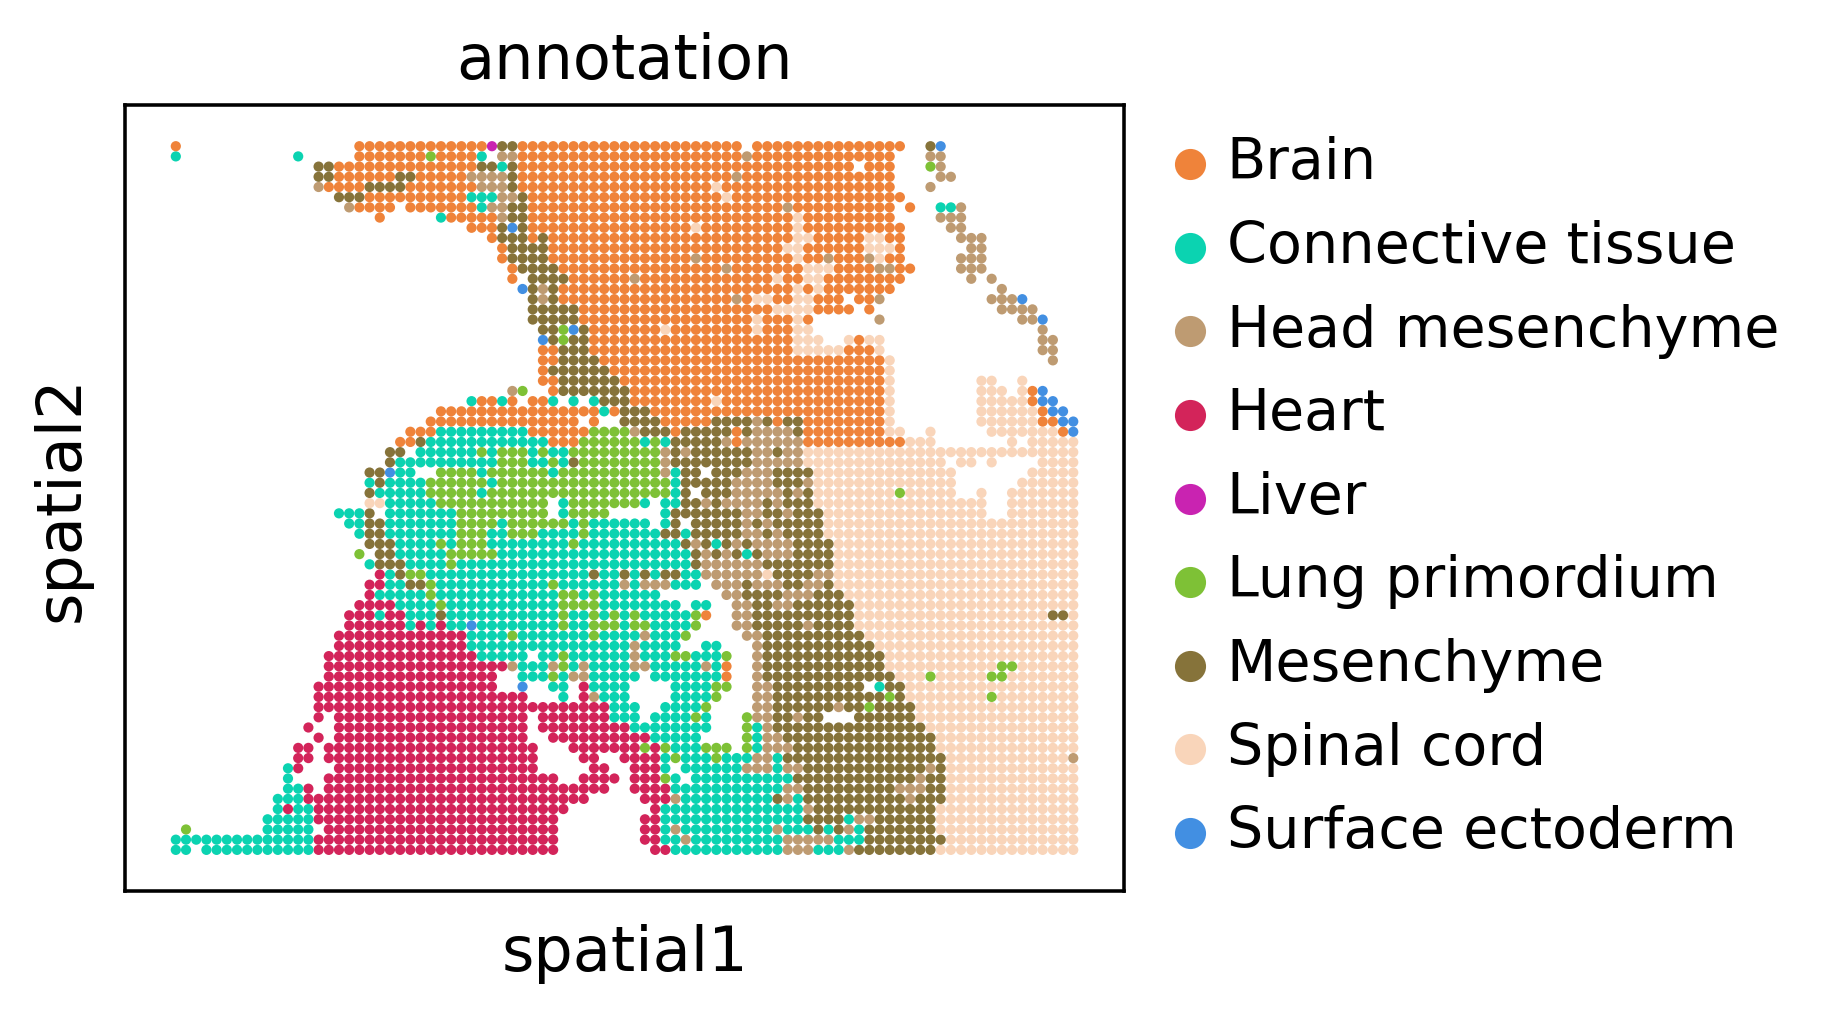

In [19]:
# filter the celltypes
rna = rna[~rna.obs['annotation'].isin(['Cavity','AGM'])]
sc.pl.spatial(rna, color="annotation", spot_size=1)

In [20]:
rna.obs['annotation'].value_counts()
rna

View of AnnData object with n_obs × n_vars = 4132 × 25544
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'annotation_colors'
    obsm: 'spatial'
    varm: 'PCs'

In [22]:
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(rna, n_top_genes=2500, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)

/tmp/ipykernel_2507824/73133845.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna.layers["counts"] = rna.X.copy()


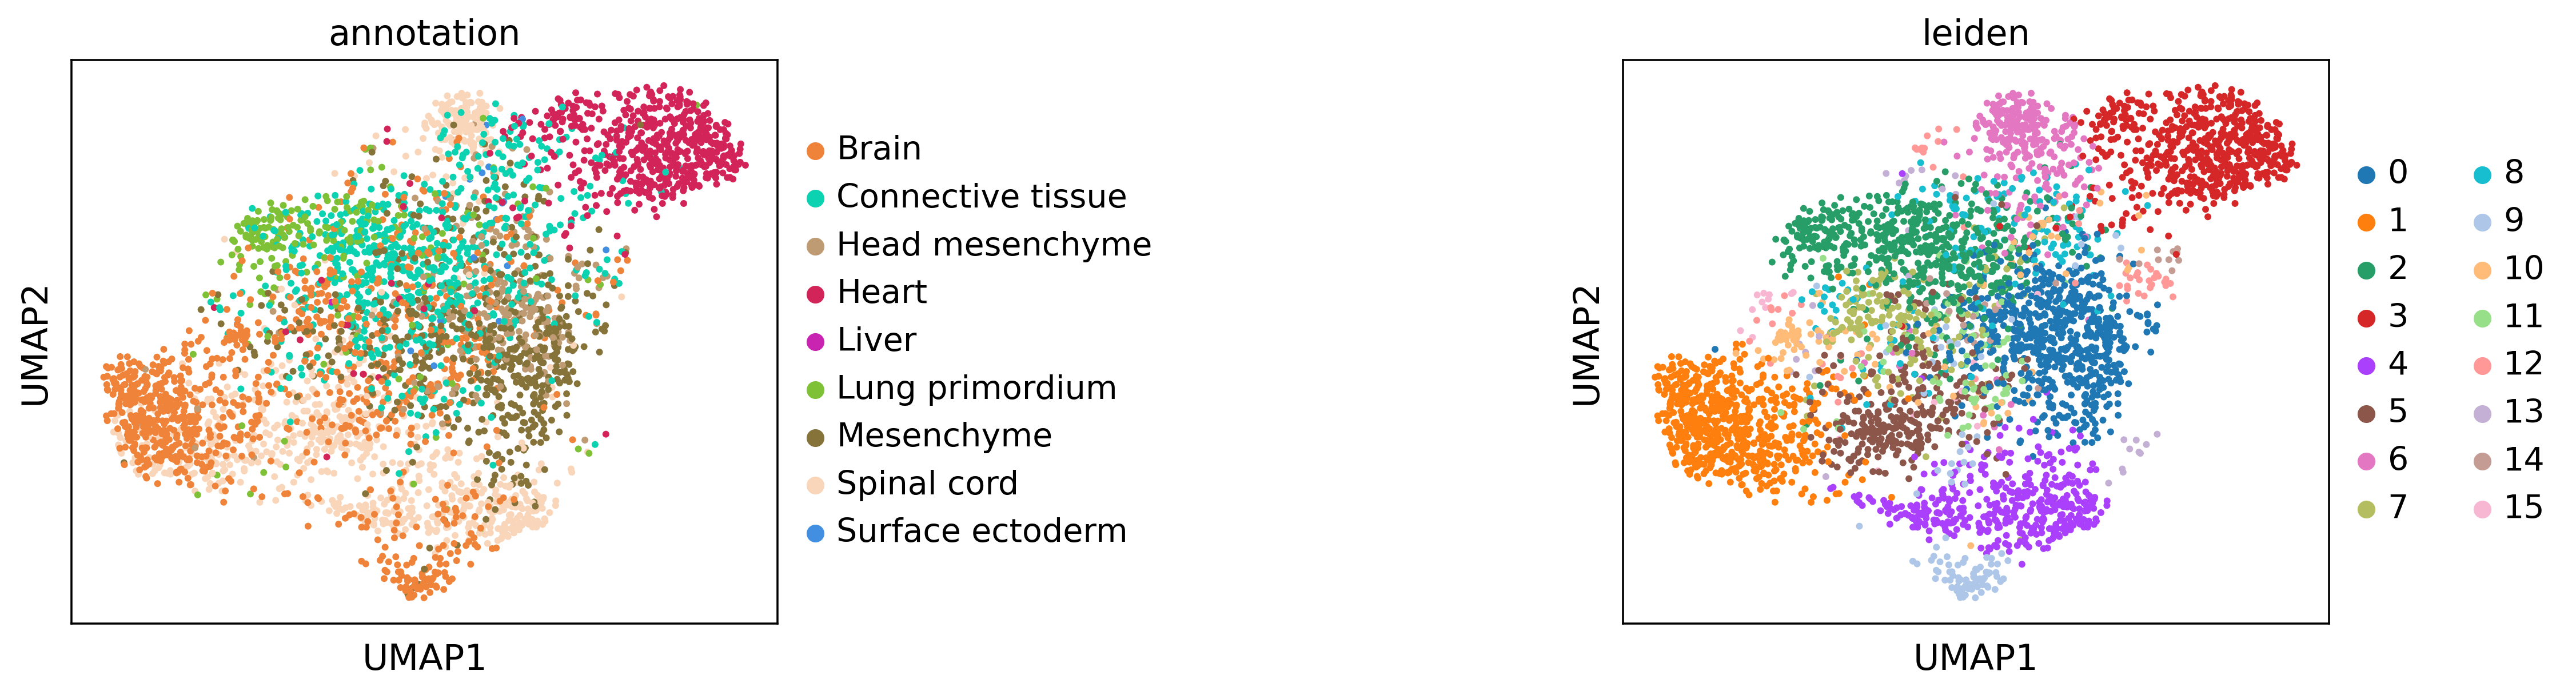

In [23]:
sc.tl.leiden(rna)
sc.pl.umap(rna, color=["annotation","leiden"],wspace=1)

# GLUE graph

In [25]:
# anno the gene with their genome coordinates
scglue.data.get_gene_annotation(
    rna, gtf="../../resource/glue/gencode.vM30.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()
rna.var['chrom'].isna().value_counts()

False    24365
True      1179
Name: chrom, dtype: int64

In [26]:
## we need to remove the genes with NA value in adata.obs
rna = rna[:,~rna.var['chrom'].isna()]
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom   chromStart     chromEnd
gene_short_name                                 
4930481A15Rik    chr19    5456767.0    5472875.0
Adgrd1            chr5  129173813.0  129281663.0
Angel1           chr12   86747275.0   86773234.0
Ankrd27           chr7   35285668.0   35338651.0
Anp32a            chr9   62248574.0   62286094.0

In [27]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1])
atac.var["chromEnd"] = split.map(lambda x: x[2])
atac.var.head()

seqnames   start     end  width strand  \
GL456211.1:116012-116275  GL456211.1  116012  116275    264      *   
GL456216.1:15617-17416    GL456216.1   15617   17416   1800      *   
GL456216.1:49018-49407    GL456216.1   49018   49407    390      *   
GL456221.1:128651-128855  GL456221.1  128651  128855    205      *   
GL456233.1:39046-39272    GL456233.1   39046   39272    227      *   

                                  name  score  fold_change  \
GL456211.1:116012-116275  macs2_peak_1     43      3.41289   
GL456216.1:15617-17416    macs2_peak_2    289      5.65476   
GL456216.1:49018-49407    macs2_peak_3    180      6.50074   
GL456221.1:128651-128855  macs2_peak_4     48      3.57541   
GL456233.1:39046-39272    macs2_peak_5     67      4.06296   

                          neg_log10pvalue_summit  neg_log10qvalue_summit  \
GL456211.1:116012-116275                 6.87857                 4.30189   
GL456216.1:15617-17416                  33.39540                28.90610   
GL456216.1:49018-49407                  21.60860                18.06300   
GL456221.1:128651-128855                 7.51443                 4.88281   
GL456233.1:39046-39272                   9.53184                 6.74323   

                          relative_summit_position       chrom chromStart  \
GL456211.1:116012-116275                       190  GL456211.1     116012   
GL456216.1:15617-17416                         624  GL456216.1      15617   
GL456216.1:49018-49407                         131  GL456216.1      49018   
GL456221.1:128651-128855                        71  GL456221.1     128651   
GL456233.1:39046-39272                          99  GL456233.1      39046   

                         chromEnd  
GL456211.1:116012-116275   116275  
GL456216.1:15617-17416      17416  
GL456216.1:49018-49407      49407  
GL456221.1:128651-128855   128855  
GL456233.1:39046-39272      39272

In [28]:
guidance = scglue.genomics.rna_anchored_prior_graph(rna, atac)
guidance.number_of_nodes(), guidance.number_of_edges()

  0%|          | 0/24365 [00:00<?, ?it/s]

(57845, 101119)

# Train GLUE

In [29]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

/rd2/user/xiacr/spatialGLUE/env/glue/conda/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [30]:
guidance = guidance.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

In [31]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] SCGLUEModel: Setting `graph_batch_size` = 3487
[INFO] SCGLUEModel: Setting `max_epochs` = 548
[INFO] SCGLUEModel: Setting `patience` = 46
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 23
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.598, 'g_kl': 0.026, 'g_elbo': 0.624, 'x_rna_nll': 0.213, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.222, 'x_atac_nll': 0.226, 'x_atac_kl': 0.004, 'x_atac_elbo': 0.23, 'dsc_loss': 0.687, 'vae_loss': 0.477, 'gen_loss': 0.442}, val={'g_nll': 0.598, 'g_kl': 0.026, 'g_elbo': 0.625, 'x_rna_nll': 0.214, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.221, 'x_atac_nll': 0.229, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.233, 'dsc_loss': 0.69, 'vae_loss': 0.479, 'gen_loss': 0.444}, 1.6s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.54, 'g_kl': 0.034, 'g_elbo': 0.574, 'x_rna_nll': 0.201, 'x_rna_kl': 0.0

2022-09-16 20:20:33,303 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "223"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (13, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 3487
[INFO] SCGLUEModel: Setting `align_burnin` = 92
[INFO] SCGLUEModel: Setting `max_epochs` = 548
[INFO] SCGLUEModel: Setting `patience` = 46
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 23
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.438, 'g_kl': 0.029, 'g_elbo': 0.468, 'x_rna_nll': 0.185, 'x_rna_kl': 0.005, 'x_rna_elbo': 0.189, 'x_atac_nll': 0.219, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.222, 'dsc_loss': 0.696, 'vae_loss': 0.43, 'gen_loss': 0.395}, val={'g_nll': 0.438, 'g_kl':

2022-09-16 20:26:35,264 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "223"...


In [32]:
glue.save("glue.dill")

In [35]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'
combined = anndata.concat([rna, atac],join='outer')
# combined = rna.concatenate(atac)

In [36]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.tl.leiden(combined, resolution=1)

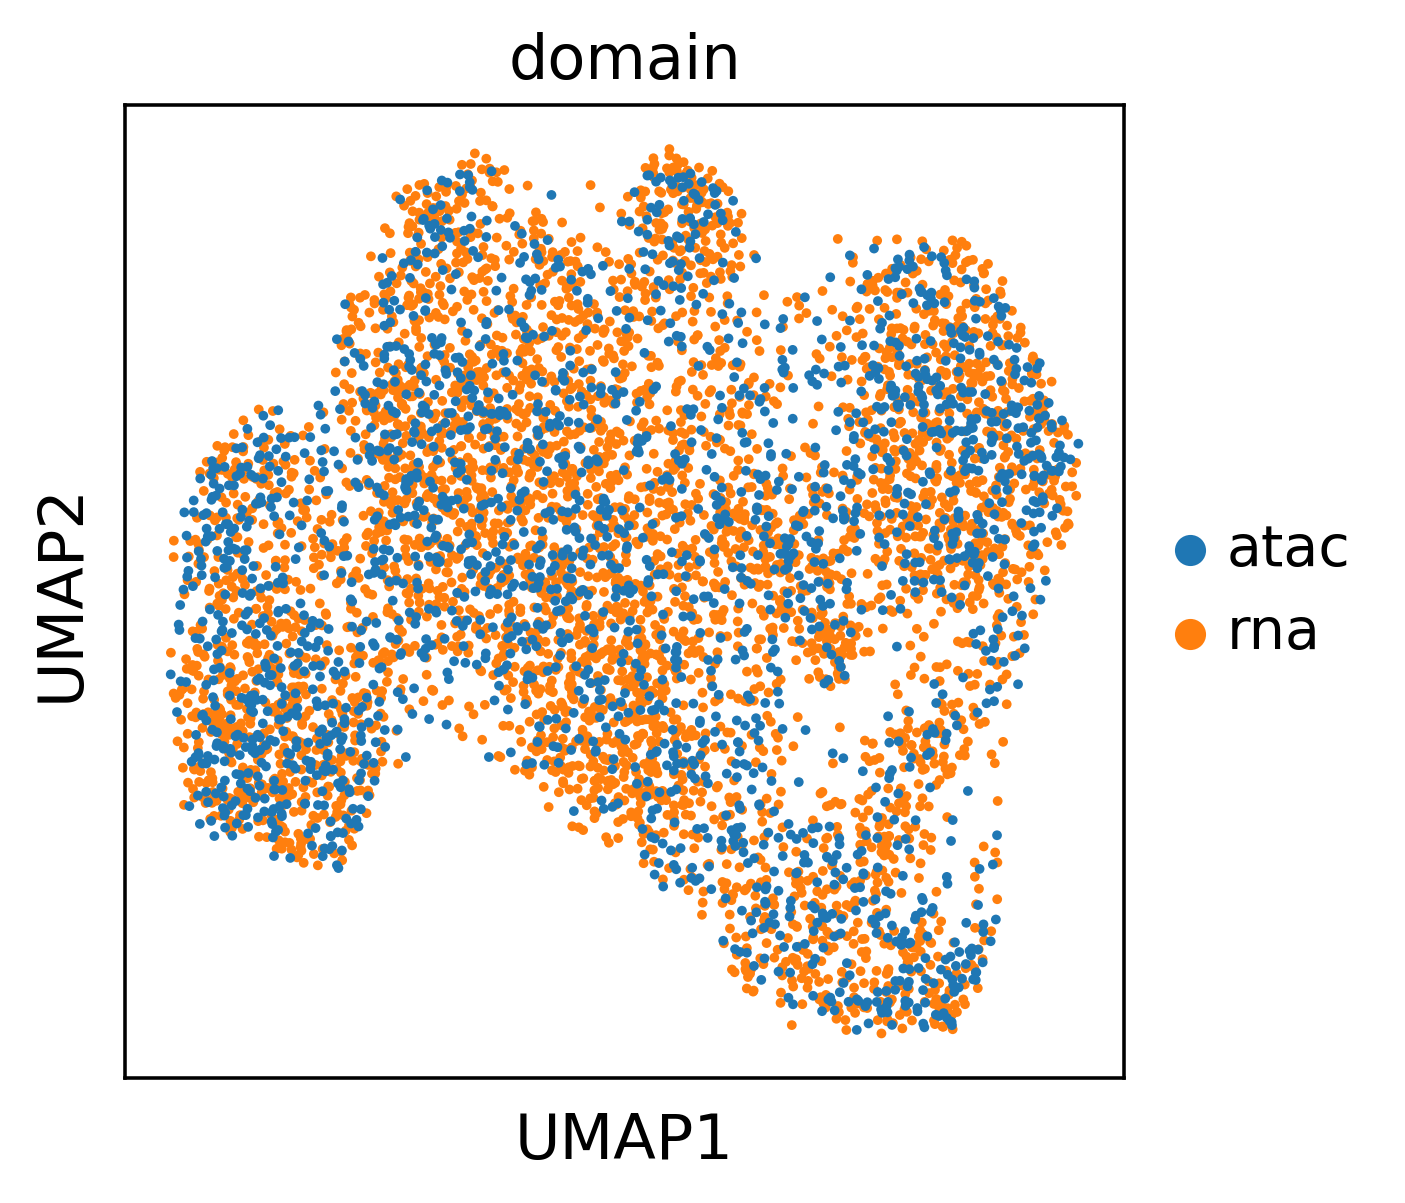

In [37]:
sc.pl.umap(combined, color=['domain'], wspace=0.6)

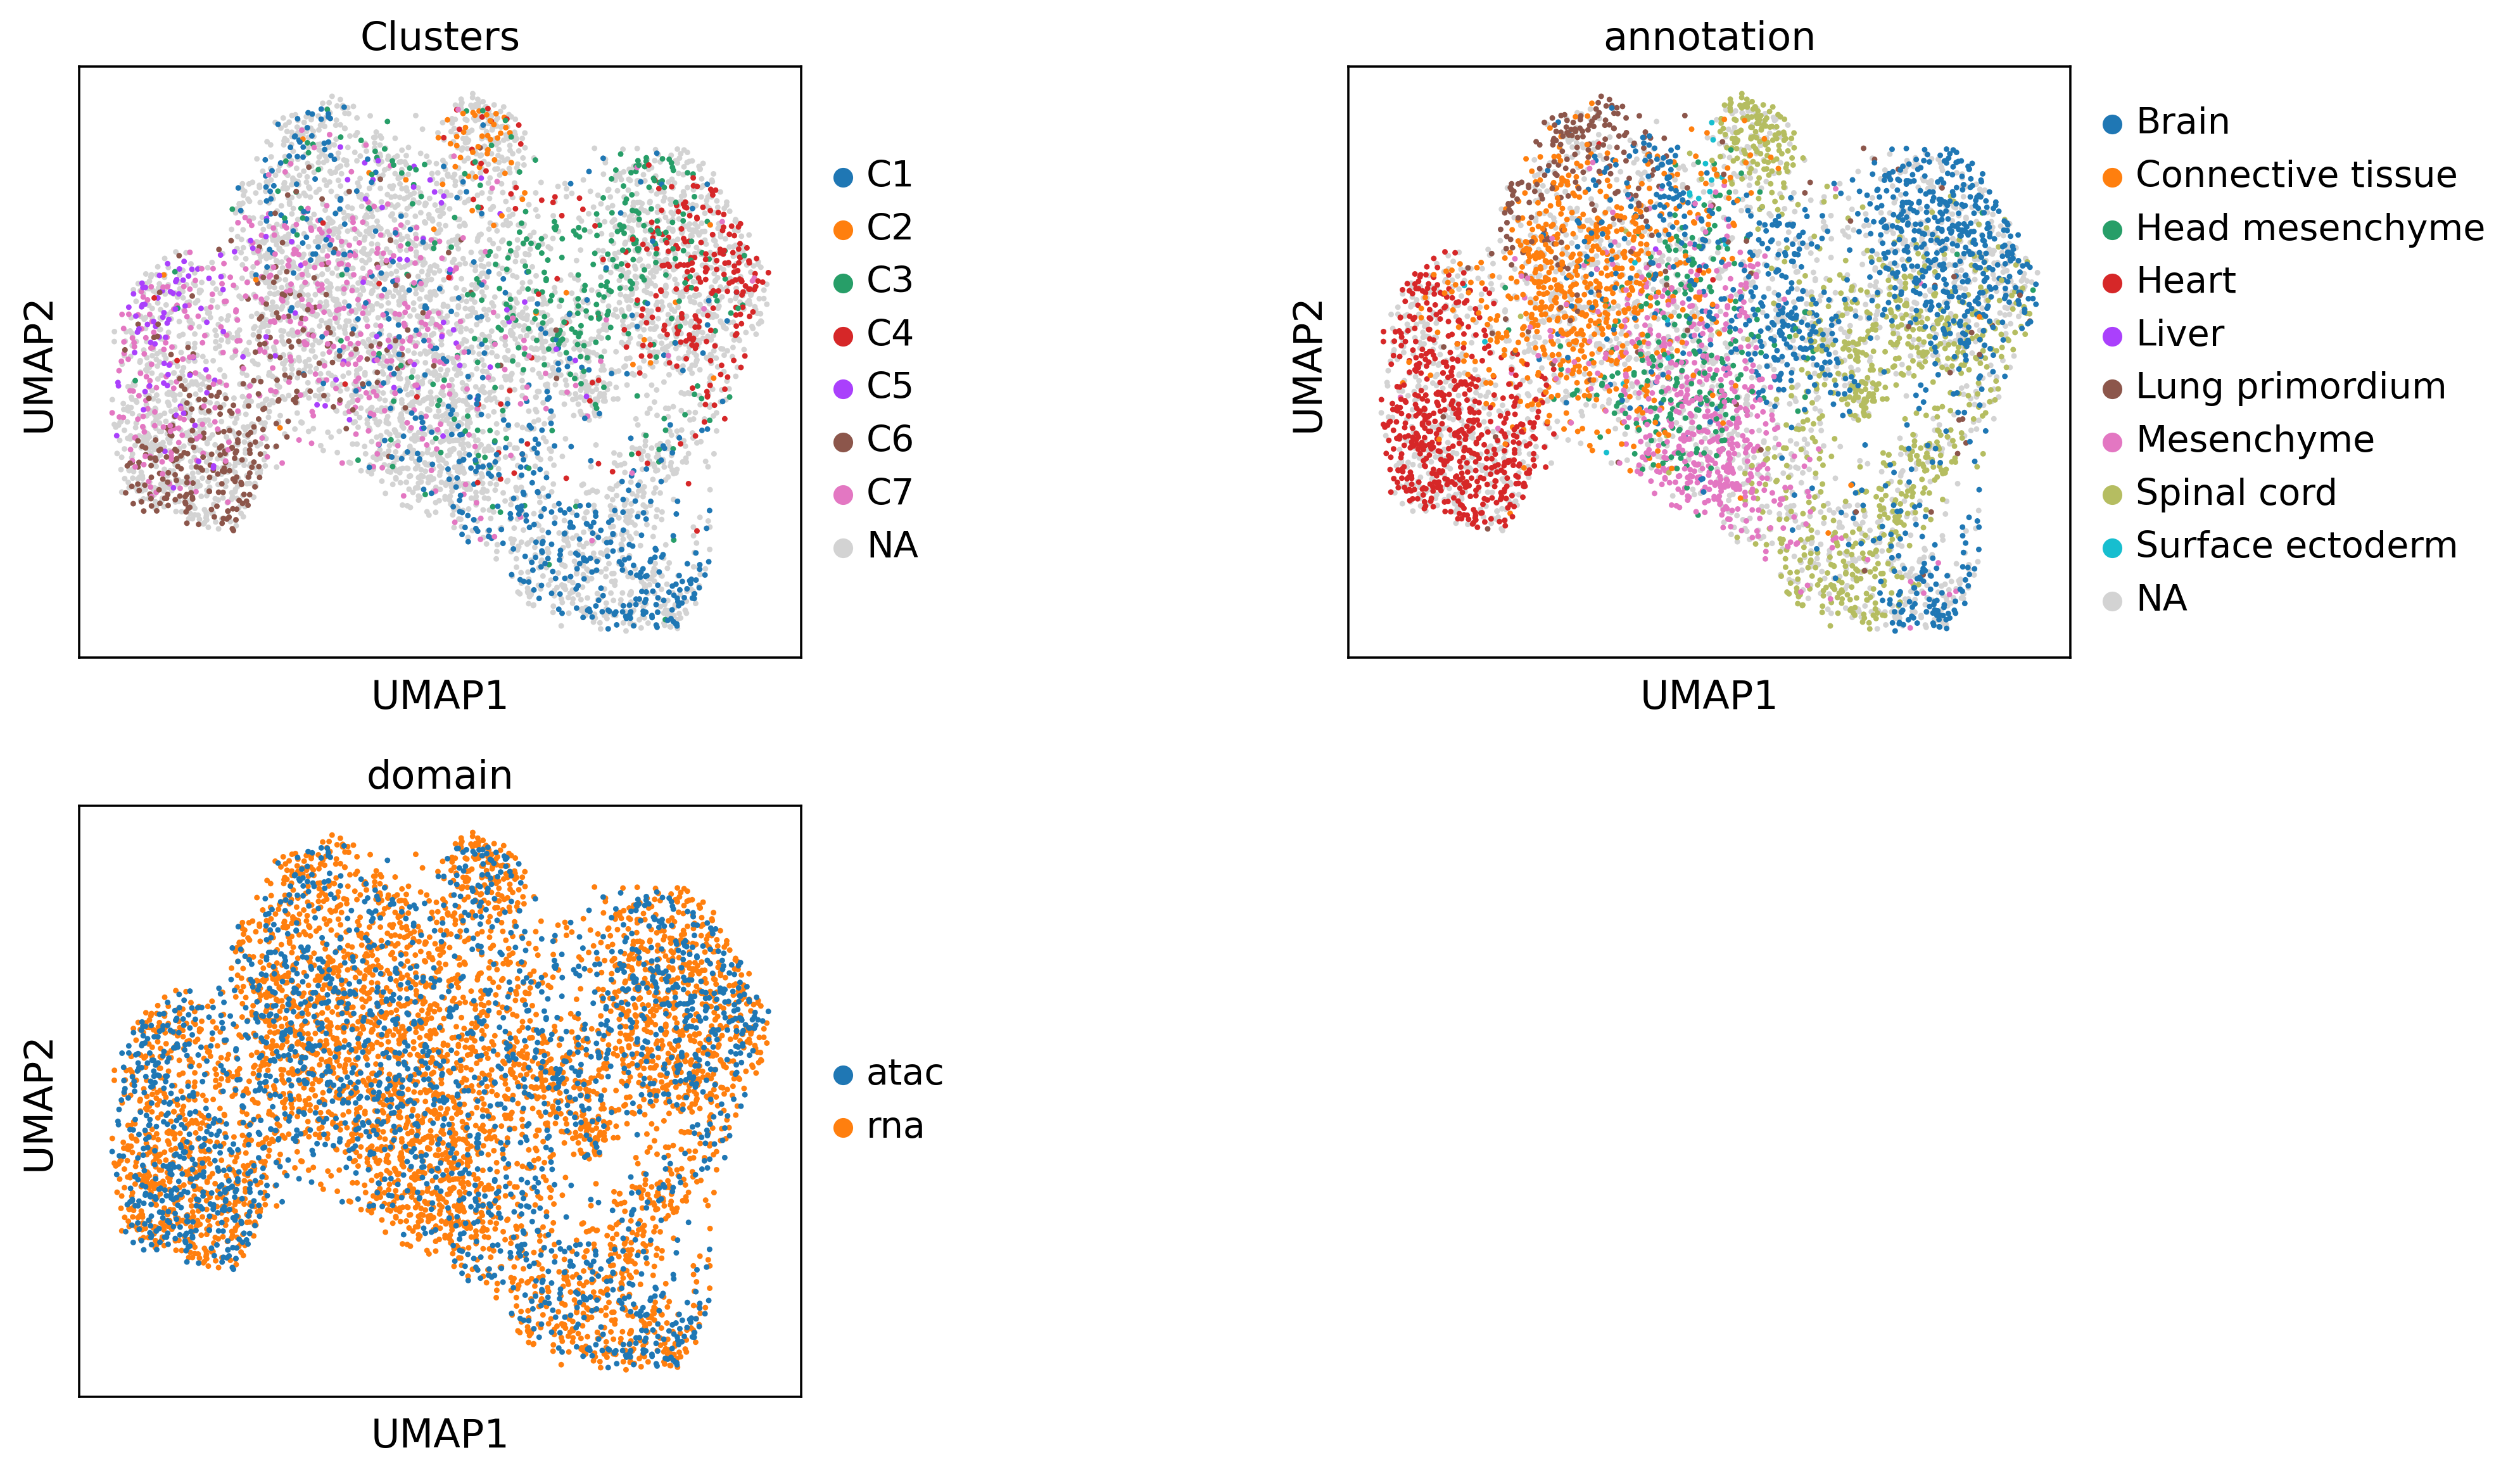

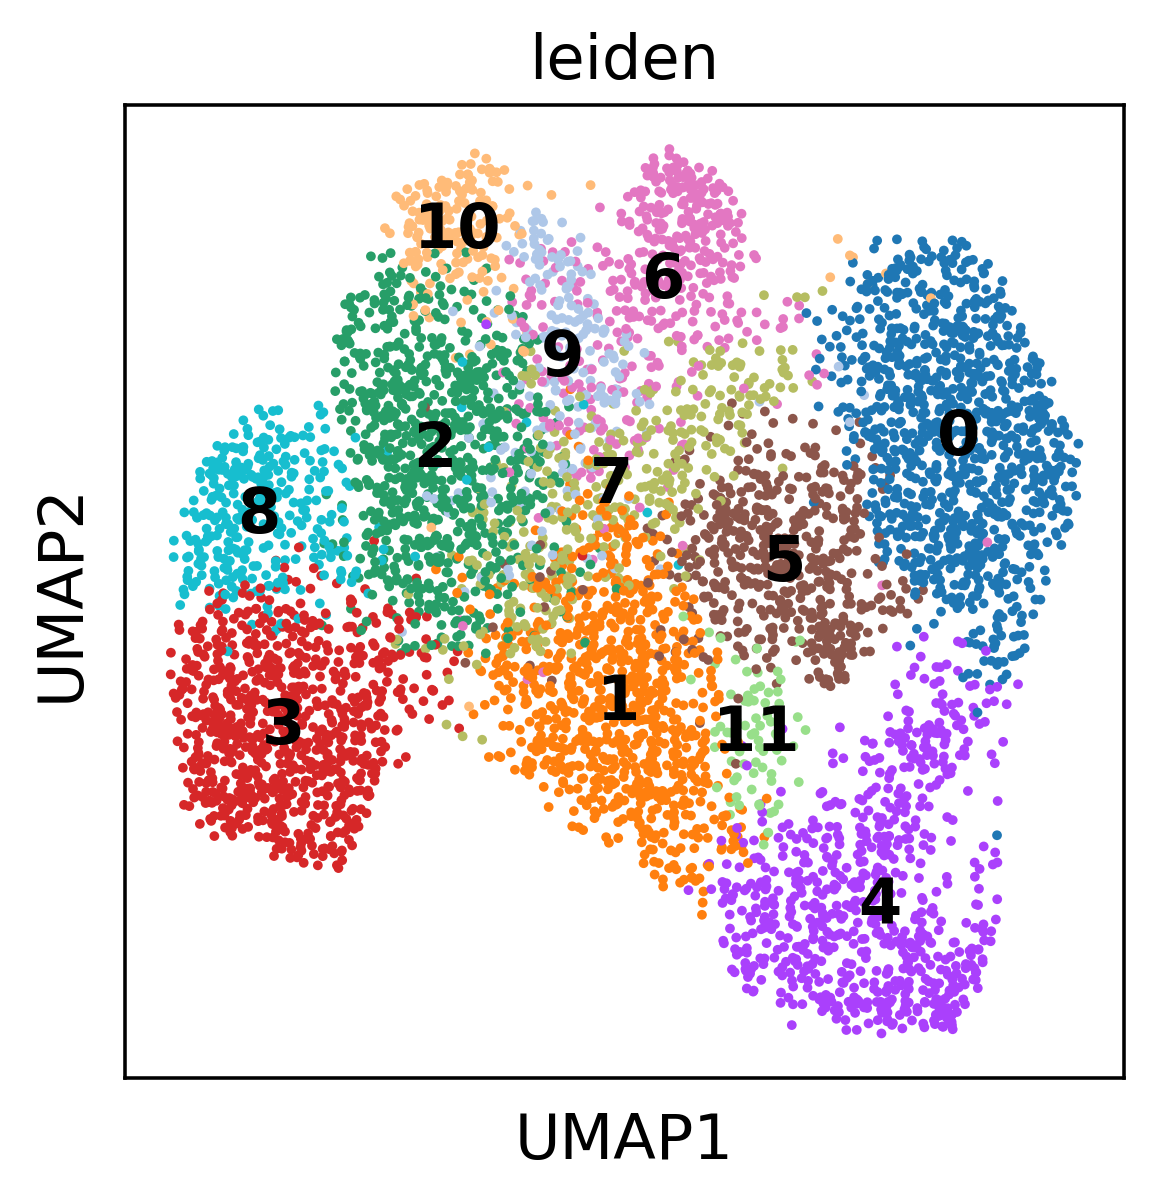

In [38]:
sc.pl.umap(combined, color=['Clusters','annotation','domain'], wspace=0.6, size=16, ncols=2)
sc.pl.umap(combined, color=['leiden'], legend_loc='on data')

# Save

In [41]:
combined.write_h5ad('./glue_combined-E11_20um.h5ad')

In [42]:
rna.write_h5ad('./glue_rna-E11_20um.h5ad')
atac.write_h5ad('./glue_atac-E11_20um.h5ad')